In this notebook, we're pre-processing the test portion of our dataset for topic modeling. We've split the preparation of train and test datasets into two separate notebooks so we can run them at the same time on different cores, making the process faster. First, we'll load the datasets from Handelsblatt, SZ, Welt, and dpa.

In [1]:
import os
import pandas as pd
from ast import literal_eval
from datetime import datetime
startTime = datetime.now()

# Set the path variable to point to the 'newspaper_data_processing' directory.
path = os.getcwd().replace('\\newspaper_analysis\\topics', '\\newspaper_data_processing')

# Load pre-processed 'dpa' dataset from a CSV file.
dpa = pd.read_csv(path + '\\dpa\\' + 'dpa_prepro_final.csv', encoding = 'utf-8', sep=';', index_col = 0,  keep_default_na=False,
                   dtype = {'rubrics': 'str', 
                            'source': 'str',
                            'keywords': 'str',
                            'title': 'str',
                            'city': 'str',
                            'genre': 'str',
                            'wordcount': 'str'},
                  converters = {'paragraphs': literal_eval})

# Keep only the article texts and their respective publication dates.
dpa = dpa[['texts', 'day', 'month', 'year']]

# Load pre-processed 'SZ' dataset from a CSV file.
sz = pd.read_csv(path + '\\SZ\\' + 'sz_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'newspaper': 'str',
                                                                                                 'newspaper_2': 'str',
                                                                                                 'quelle_texts': 'str',
                                                                                                 'page': 'str',
                                                                                                 'rubrics': 'str'})
sz.page = sz.page.fillna('')
sz.newspaper = sz.newspaper.fillna('')
sz.newspaper_2 = sz.newspaper_2.fillna('')
sz.rubrics = sz.rubrics.fillna('')
sz.quelle_texts = sz.quelle_texts.fillna('')

# Keep only the article texts and their respective publication dates.
sz = sz[['texts', 'day', 'month', 'year']]

# Load pre-processed 'Handelsblatt' dataset from a CSV file.
hb = pd.read_csv(path + '\\Handelsblatt\\' + 'hb_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'kicker': 'str',
                                                                                                 'page': 'str',
                                                                                                 'series_title': 'str',
                                                                                                 'rubrics': 'str'})
hb.page = hb.page.fillna('')
hb.series_title = hb.series_title.fillna('')
hb.kicker = hb.kicker.fillna('')
hb.rubrics = hb.rubrics.fillna('')

# Keep only the article texts and their respective publication dates.
hb = hb[['texts', 'day', 'month', 'year']]

# Load pre-processed 'Welt' dataset from a CSV file.
welt = pd.read_csv(path + '\\Welt\\' + 'welt_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'newspaper': 'str',
                                                                                                 'rubrics': 'str',
                                                                                                 'title': 'str'})
welt.title = welt.title.fillna('')
welt.rubrics = welt.rubrics.fillna('')

# Keep only the article texts and their respective publication dates.
welt = welt[['texts', 'day', 'month', 'year']]

# Concatenate the 'dpa', 'sz', 'hb', and 'welt' DataFrames into a single DataFrame 'data'.
data = pd.concat([dpa, sz, hb, welt])

# The number of articles in the final dataset.
print(len(data))

# Sort the data in chronological order.
data = data.sort_values(['year', 'month', 'day'], ascending=[True, True, True])
# Reset the index of the DataFrame
data.reset_index(inplace=True, drop=True)
data.head()

3336299


,texts,day,month,year
0,Schalck: Milliardenkredit sicherte Zahlungsfäh...,1,1,1991
1,Welajati: Iran bleibt bei einem Krieg am Golf ...,1,1,1991
2,Bush will offenbar seinen Außenminister erneut...,1,1,1991
3,Sperrfrist 1. Januar 1000 HBV fordert umfassen...,1,1,1991
4,Schamir weist Nahost-Äußerungen des neuen EG-P...,1,1,1991


Next, we import sentiment scores, previously computed using an LSTM model for each article in the corpus.

In [2]:
import csv
import codecs

# Set the path variable to point to the 'sentiment' directory.
path = os.getcwd().replace('\\topics', '') + '\\sentiment'

with codecs.open(path + "\\scores_lstm.csv", "r", encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    scores = [None if row[0] == '' else float(row[0]) for row in reader]

We add sentiment scores as a new column to the `data` DataFrame and discard any rows with missing sentiment scores.

In [3]:
# Add the sentiment scores as a new column in the data DataFrame
data['scores'] = scores

# Remove any rows in the DataFrame where a sentiment score is missing (NaN). In this context, 
# NaN corresponds to the model's inability to predict sentiment for certain 
# articles due to formatting issues or because the article is too short (less than 20 tokens).
data = data.dropna(subset=['scores'])

# Reset the index of the DataFrame
data.reset_index(inplace=True, drop=True)

In this project, our test dataset consists of articles published from 2010 onward. The motivation behind this decision is our objective of generating an out-of-sample forecast of GDP growth for the years 2010 to 2018. By assigning articles published in 2010 and later to the test set, we ensure our model's forecasts are based only on information available up to 2009, thereby preserving the integrity of our out-of-sample predictions.

In [4]:
# Filter the dataset to include only articles published after 2010.
data = data[data.year >= 2010]

To pre-process the data for topic modeling, we use the `RawDocs` class from Stephen Hansen's [`topic-modelling-tools`](https://www.dropbox.com/s/gxkqgjwc50qjtg5/topic-modelling-tools-with_gsl.zip?dl=0). We adapt the pre-processing steps to meet the specific requirements of our current project. 

Here's what we do:

1. We create single terms out of two-word (and three-word) collocations. This involves combining the words in each collocation into a single term, using an underscore. This can help the model to understand and use the combined meaning of the collocations better, rather than treating each word individually. Nonetheless, to alleviate computational load, we limit our focus to the 2,000 most frequent two-word collocations and the 1,000 most frequent three-word collocations.

2. We convert all upper-case to lower-case letters.

3. We remove all apostrophes.

4. We tokenize a text. A token is the technical name for a sequence of characters that we want to treat as a group.

In [5]:
import topicmodels
docsobj = topicmodels.RawDocs(data.texts)

5. We remove non-alphabetic characters (including numbers, punctuation, and currency symbols) and single-character words. However, we retain words that include an underscore, as these represent collocations.

In [6]:
docsobj.token_clean(1)
print docsobj.tokens[0]

[u'zusammenfassung', u'spanien', u'\xfcbernimmt', u'von', u'schweden', u'eu', u'vorsitz', u'madrid', u'spanien', u'hat', u'als', u'nachfolger', u'schwedens', u'zum', u'jahreswechsel', u'f\xfcr', u'sechs', u'monate', u'die', u'ratspr\xe4sidentschaft', u'der', u'europ\xe4ischen_union', u'\xfcbernommen', u'der', u'spanische', u'eu', u'vorsitz', u'ist', u'der', u'erste', u'nach', u'dem', u'inkrafttreten', u'des', u'lissabon', u'reformvertrages', u'und', u'leitet', u'damit', u'eine', u'neue_\xe4ra', u'ein', u'die', u'f\xfchrungsrolle', u'kommt', u'dem', u'neuen', u'st\xe4ndigen', u'ratspr\xe4sidenten', u'herman', u'van', u'rompuy', u'zu', u'er', u'wird', u'auch', u'die', u'eu', u'gipfel', u'leiten', u'madrid', u'werde', u'sich', u'zur\xfccknehmen', u'und', u'dem', u'belgier', u'den', u'vortritt', u'lassen', u'sagte', u'der', u'spanische_regierungschef', u'und', u'turnusm\xe4\xdfige', u'eu', u'vorsitzende', u'jos\xe9_luis_rodr\xedguez_zapatero', u'zur', u'begr\xfc\xdfung', u'der', u'ratspr\x

6. We remove stop words. Stop words are a set of very frequently used words that do not convey meaning by themselves, like ‘aber’, ‘alle’, ‘allem’. 

In [7]:
docsobj.stopword_remove("tokens")
print docsobj.tokens[0]

[u'zusammenfassung', u'spanien', u'\xfcbernimmt', u'schweden', u'eu', u'vorsitz', u'madrid', u'spanien', u'nachfolger', u'schwedens', u'jahreswechsel', u'sechs', u'monate', u'ratspr\xe4sidentschaft', u'europ\xe4ischen_union', u'\xfcbernommen', u'spanische', u'eu', u'vorsitz', u'erste', u'inkrafttreten', u'lissabon', u'reformvertrages', u'leitet', u'neue_\xe4ra', u'f\xfchrungsrolle', u'kommt', u'neuen', u'st\xe4ndigen', u'ratspr\xe4sidenten', u'herman', u'van', u'rompuy', u'eu', u'gipfel', u'leiten', u'madrid', u'zur\xfccknehmen', u'belgier', u'vortritt', u'lassen', u'sagte', u'spanische_regierungschef', u'turnusm\xe4\xdfige', u'eu', u'vorsitzende', u'jos\xe9_luis_rodr\xedguez_zapatero', u'begr\xfc\xdfung', u'ratspr\xe4sidentschaft', u'erstrahlten', u'nacht_zum_freitag', u'dutzend', u'wahrzeichen', u'spaniens', u'blauen', u'farbe', u'eu', u'flagge', u'z\xe4hlten', u'k\xf6nigspalast', u'madrid', u'aqu\xe4dukt', u'segovia', u'herkules', u'turm', u'la', u'coru\xf1a', u'bellver', u'schloss'

7. We remove common German first names and surnames. The former are retrieved from [Script](https://script.byu.edu/german-handwriting/tools/given-names) and [beliebte-vornamen.de](https://www.beliebte-vornamen.de/). We get the list of surnames from [Digital Dictionary of Surnames in Germany](http://www.namenforschung.net/en/dfd/dictionary/list-of-all-published-entries/).

The rationale behind this step is to prevent the creation of topics where names or surnames become the most probable words. Topics dominated by names or surnames do not provide valuable insights for our research objectives. Furthermore, the removal of common names and surnames is a standard practice in text processing within the field of topic modeling.

In [8]:
docsobj.words_remove(docsobj.names)
print docsobj.tokens[0]

[u'zusammenfassung', u'spanien', u'\xfcbernimmt', u'schweden', u'eu', u'vorsitz', u'madrid', u'spanien', u'nachfolger', u'schwedens', u'jahreswechsel', u'sechs', u'monate', u'ratspr\xe4sidentschaft', u'europ\xe4ischen_union', u'\xfcbernommen', u'spanische', u'eu', u'vorsitz', u'erste', u'inkrafttreten', u'lissabon', u'reformvertrages', u'leitet', u'neue_\xe4ra', u'f\xfchrungsrolle', u'kommt', u'neuen', u'st\xe4ndigen', u'ratspr\xe4sidenten', u'rompuy', u'eu', u'gipfel', u'leiten', u'madrid', u'zur\xfccknehmen', u'belgier', u'vortritt', u'lassen', u'sagte', u'spanische_regierungschef', u'turnusm\xe4\xdfige', u'eu', u'vorsitzende', u'jos\xe9_luis_rodr\xedguez_zapatero', u'begr\xfc\xdfung', u'ratspr\xe4sidentschaft', u'erstrahlten', u'nacht_zum_freitag', u'dutzend', u'wahrzeichen', u'spaniens', u'blauen', u'farbe', u'eu', u'flagge', u'z\xe4hlten', u'k\xf6nigspalast', u'madrid', u'aqu\xe4dukt', u'segovia', u'herkules', u'turm', u'la', u'coru\xf1a', u'bellver', u'schloss', u'palma', u'de', 

8. We stem the tokens. Stemming is the process of reducing words that have different grammatical forms but share a common meaning to their word stem. For instance, all words ‘kategorisch’, ‘kategorische’, ‘kategorischen’ have the same stem ‘kategor’. We use a Porter Stemmer for German language which is the most popular algorithm for stemming. Details on the Porter Stemmer can be found [here](http://snowball.tartarus.org/algorithms/german/stemmer.html).

In [9]:
docsobj.stem()
print docsobj.stems[0]

[u'zusammenfass', u'spani', u'ubernimmt', u'schwed', u'eu', u'vorsitz', u'madrid', u'spani', u'nachfolg', u'schwed', u'jahreswechsel', u'sech', u'monat', u'ratsprasidentschaft', u'europ\xe4ischen_union', u'ubernomm', u'spanisch', u'eu', u'vorsitz', u'erst', u'inkrafttret', u'lissabon', u'reformvertrag', u'leitet', u'neue_\xe4ra', u'fuhrungsroll', u'kommt', u'neu', u'standig', u'ratsprasident', u'rompuy', u'eu', u'gipfel', u'leit', u'madrid', u'zurucknehm', u'belgi', u'vortritt', u'lass', u'sagt', u'spanische_regierungschef', u'turnusmass', u'eu', u'vorsitz', u'jos\xe9_luis_rodr\xedguez_zapatero', u'begruss', u'ratsprasidentschaft', u'erstrahlt', u'nacht_zum_freitag', u'dutzend', u'wahrzeich', u'spani', u'blau', u'farb', u'eu', u'flagg', u'zahlt', u'konigspalast', u'madrid', u'aquadukt', u'segovia', u'herkul', u'turm', u'la', u'coru\xf1a', u'bellv', u'schloss', u'palma', u'de', u'mallorca', u'mittelpunkt', u'spanisch', u'eu', u'vorsitz', u'motto', u'innovation', u'europa', u'verabschied

9. To ensure that all stopwords are fully eliminated, especially after the stemming process which might have transformed some words into stopwords, we conduct an additional removal of stopwords. 

In [10]:
docsobj.stopword_remove('stems')
print docsobj.stems[0]

[u'zusammenfass', u'spani', u'ubernimmt', u'schwed', u'eu', u'vorsitz', u'madrid', u'spani', u'nachfolg', u'schwed', u'jahreswechsel', u'sech', u'monat', u'ratsprasidentschaft', u'europ\xe4ischen_union', u'ubernomm', u'spanisch', u'eu', u'vorsitz', u'erst', u'inkrafttret', u'lissabon', u'reformvertrag', u'leitet', u'neue_\xe4ra', u'fuhrungsroll', u'kommt', u'neu', u'standig', u'ratsprasident', u'rompuy', u'eu', u'gipfel', u'leit', u'madrid', u'zurucknehm', u'belgi', u'vortritt', u'lass', u'sagt', u'spanische_regierungschef', u'turnusmass', u'eu', u'vorsitz', u'jos\xe9_luis_rodr\xedguez_zapatero', u'begruss', u'ratsprasidentschaft', u'erstrahlt', u'nacht_zum_freitag', u'dutzend', u'wahrzeich', u'spani', u'blau', u'farb', u'eu', u'flagg', u'zahlt', u'konigspalast', u'madrid', u'aquadukt', u'segovia', u'herkul', u'turm', u'la', u'coru\xf1a', u'bellv', u'schloss', u'palma', u'de', u'mallorca', u'mittelpunkt', u'spanisch', u'eu', u'vorsitz', u'motto', u'innovation', u'europa', u'verabschied

10. Discard the tokens with the lowest tf-idf score. tf-idf stands for term frequency – inverse document frequency and is defined by the following formula for each token $v$:

$$\text{tf-idf}_v = \log(1+N_v)× \log⁡\left(\frac{D}{D_v}\right)$$

where
$N_v$ – the count of the token $v$ in the corpus,
$D_v$ – the number of documents that contain the term $v$,
$D$ - the number of documents.

This numerical statistic is lower for those tokens that appear in the documents very rarely or very frequently. Dimensionality reduction is the main goal of the step. 

In [11]:
docsobj.term_rank("stems")
print(datetime.now()-startTime)

2:12:47.320000


We implement a thresholding mechanism, eliminating all stems whose tf-idf score is equal to or less than the tf-idf score of the 300,000th stem. The threshold value is determined based on the analysis of the training portion of our dataset.

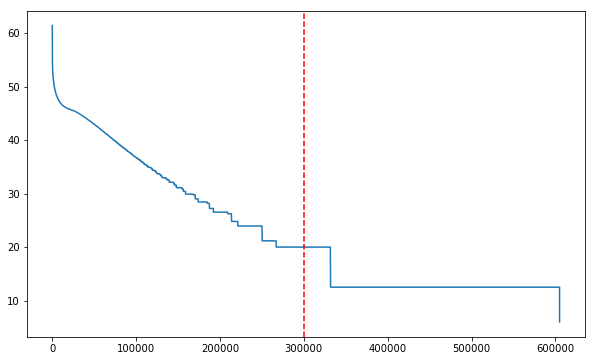

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot([x[1] for x in docsobj.tfidf_ranking])
plt.axvline(x=300000, color='r', linestyle='--')  # Add vertical line at index 300000
plt.show()

In [13]:
docsobj.rank_remove("tfidf","stems",docsobj.tfidf_ranking[300000][1])
all_stems = [s for d in docsobj.stems for s in d]
print("number of unique stems = %d" % len(set(all_stems)))
print("number of total stems = %d" % len(all_stems))

number of unique stems = 266948
number of total stems = 55961795


In [14]:
print docsobj.stems[0]

[u'zusammenfass', u'spani', u'ubernimmt', u'schwed', u'vorsitz', u'madrid', u'spani', u'nachfolg', u'schwed', u'jahreswechsel', u'sech', u'monat', u'ratsprasidentschaft', u'europ\xe4ischen_union', u'ubernomm', u'spanisch', u'vorsitz', u'inkrafttret', u'lissabon', u'reformvertrag', u'leitet', u'neue_\xe4ra', u'fuhrungsroll', u'kommt', u'standig', u'ratsprasident', u'rompuy', u'gipfel', u'leit', u'madrid', u'zurucknehm', u'belgi', u'vortritt', u'lass', u'spanische_regierungschef', u'turnusmass', u'vorsitz', u'jos\xe9_luis_rodr\xedguez_zapatero', u'begruss', u'ratsprasidentschaft', u'erstrahlt', u'nacht_zum_freitag', u'dutzend', u'wahrzeich', u'spani', u'blau', u'farb', u'flagg', u'zahlt', u'konigspalast', u'madrid', u'segovia', u'herkul', u'turm', u'la', u'coru\xf1a', u'schloss', u'palma', u'de', u'mallorca', u'mittelpunkt', u'spanisch', u'vorsitz', u'motto', u'innovation', u'verabschied', u'strategi', u'wirtschaftsaufschw', u'steh', u'februar', u'sondergipfel', u'geplant', u'ausserd', u

In [15]:
import pickle

with open('stems_for_lda_test.pkl', 'wb') as f:
    pickle.dump(docsobj.stems, f)

In [16]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>